[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeyabbalas/py-icare/blob/master/examples/Python/Covariate-only%20absolute%20risk%20model.ipynb)

# Covariate-only absolute risk model

In this example, we demonstrate the use of iCARE to build models of absolute risk containing only classical risk factors. Here, we assume that we have a reference dataset to represent the distribution of the classical risk factors in the underlying population. Note that if your model contains SNPs and you have a reference dataset, you must use the example described in this notebook. Do not make use of the special SNP-only model because it would make certain parametric assumptions about the distribution of SNPs in the underlying population.

Specifically, we will use iCARE to build and apply absolute risk model of breast cancer using known questionnaire-based classical risk factors in literature.

In [ ]:
! pip install icare --quiet

In [1]:
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns

import icare


# Set the plot background to white
sns.set(style="whitegrid", rc={"axes.facecolor": "white", "grid.color": "white"})
seed = 1234

To specify a covariate model in iCARE, we need to provide: 1) a text file containing the covariate model formula description using the [Patsy formula language](https://patsy.readthedocs.io/en/latest/formulas.html) (`model_covariate_formula_path`), 2) the breast cancer log odds ratios associated with each risk factor in the covariate model (`model_log_relative_risk_path`), 3) a reference dataset describing the distribution of the classical risk factors in the underlying population (`model_reference_dataset_path`), 4) a set of profiles, specifying the classical risk factors of individuals for whom, the absolute risk is to be estimated (`apply_covariate_profile_path`), 5) the marginal age-specific incidence rates of breast cancer (`model_disease_incidence_rates_path`), and 6) optionally, the age-specific incidence rates of competing risks (`model_competing_incidence_rates_path`). We include them in this example.

The covariate model described in the file specified below is based on a logistic regression model adjusted for cohort and fine categories of age in the Breast and Prostate Cancer Cohort Consortium ([Campa et al. 2011](https://pubmed.ncbi.nlm.nih.gov/21791674/), [Joshi et al. 2014](https://pubmed.ncbi.nlm.nih.gov/25255808/), and [Maas et al. 2016](https://pubmed.ncbi.nlm.nih.gov/27228256/)). The reference dataset was created by simulation from [the National Health Interview Survey (NHIS)](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NHIS/2010/srvydesc.pdf) and [the National Health and Nutrition Examination Survey (NHANES)](https://wwwn.cdc.gov/nchs/nhanes/default.aspx), which are representative of the US population.

In [2]:
# Data files URLs
github_source = "https://raw.githubusercontent.com/jeyabbalas/py-icare/master/data/"

model_covariate_formula_url = github_source + "breast_cancer_covariate_model_formula.txt"
model_log_relative_risk_url = github_source + "breast_cancer_model_log_odds_ratios.json"
model_reference_dataset_url = github_source + "reference_covariate_data.csv"
apply_covariate_profile_url = github_source + "query_covariate_profile.csv"
model_disease_incidence_rates_url = github_source + "age_specific_breast_cancer_incidence_rates.csv"
model_competing_incidence_rates_url = github_source + "age_specific_all_cause_mortality_rates.csv"

In [3]:
# Data will be downloaded here
data_dir = pathlib.Path("data")
data_dir.mkdir(exist_ok=True)

model_covariate_formula_path = data_dir / "breast_cancer_covariate_model_formula.txt"
model_log_relative_risk_path = data_dir / "breast_cancer_model_log_odds_ratios.json"
model_reference_dataset_path = data_dir / "reference_covariate_data.csv"
apply_covariate_profile_path = data_dir / "query_covariate_profile.csv"
model_disease_incidence_rates_path = data_dir / "age_specific_breast_cancer_incidence_rates.csv"
model_competing_incidence_rates_path = data_dir / "age_specific_all_cause_mortality_rates.csv"

In [4]:
# Download the data
for url, path in zip(
    [
        model_covariate_formula_url,
        model_log_relative_risk_url,
        model_reference_dataset_url,
        apply_covariate_profile_url,
        model_disease_incidence_rates_url,
        model_competing_incidence_rates_url,
    ],
    [
        model_covariate_formula_path,
        model_log_relative_risk_path,
        model_reference_dataset_path,
        apply_covariate_profile_path,
        model_disease_incidence_rates_path,
        model_competing_incidence_rates_path,
    ],
):
    print(f"Downloading {url} to {path}")
    response = requests.get(url)
    response.raise_for_status()
    with open(path, "wb") as f:
        f.write(response.content)

In [5]:
results = icare.compute_absolute_risk(
    apply_age_start=50,
    apply_age_interval_length=30,
    model_covariate_formula_path=model_covariate_formula_path,
    model_log_relative_risk_path=model_log_relative_risk_path,
    model_reference_dataset_path=model_reference_dataset_path,
    apply_covariate_profile_path=apply_covariate_profile_path,
    model_disease_incidence_rates_path=model_disease_incidence_rates_path,
    model_competing_incidence_rates_path=model_competing_incidence_rates_path,
    return_reference_risks=True,
    seed=seed # set the random seed for reproducibility
)

The method returns a dictionary containing the following keys:

In [6]:
results.keys()

dict_keys(['model', 'profile', 'reference_risks', 'method'])

The `method` key contains the name of the iCARE method used:

In [7]:
print(f"iCARE method used: {results['method']}")

iCARE method used: iCARE - absolute risk


The `model` key contains the absolute risk model parameters, i.e., the log odds-ratios for each classical risk factor in association with breast cancer risk:

In [8]:
model = pd.Series(results["model"])
model

C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.11-11.5]                                                                                      0.044431
C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.11.5-12]                                                                                     -0.035407
C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.12-13]                                                                                       -0.086565
C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.13-14]                                                                                       -0.109902
C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.14-15]                                                                                       -0.085482
          

The `profile` key contains the classical risk factors and the estimated absolute risk for each queried profile:

In [9]:
profiles = pd.read_json(results["profile"], orient="records")
profiles.set_index("id", inplace=True)
profiles

,age_interval_start,age_interval_end,risk_estimates,family_history,age_at_menarche,parity,age_at_first_child_birth,age_at_menopause,height,bmi,menopause_hrt,menopause_hrt_e,menopause_hrt_c,current_hrt,alcohol_consumption,smoking_status
id,,,,,,,,,,,,,,,,
Q-01,50,80,0.110947,0,13-14,0,19-22,40-45,1.63-1.65,>=34.6,1,0,0,0,none,ever
Q-02,50,80,0.082069,0,>=15,0,19-22,<=40,1.63-1.65,24.2-25.3,1,0,0,0,0.8-1.5,never
Q-03,50,80,0.120892,0,<=11,0,<=19,51-52,<=1.55,>=34.6,1,0,0,0,none,ever


The `reference_risks` key contains the absolute risks of the reference population. The population estimated risks are stored in the `reference_risks` key. It contains a list of dictionaries, one per unique combination of age intervals. Since, we calculated the risks for the interval from age 50 to 80 for all individuals, there is only one dictionary in the list:

In [10]:
reference_risks = results["reference_risks"]

We can calculate the summary statistics of the reference population risks as shown below. We can see that the population mean risk is `0.096`.

In [11]:
pd.Series(reference_risks[0]["population_risks"]).describe().apply(lambda x: format(x, 'f'))

count    14137.000000
mean         0.095992
std          0.029169
min          0.037990
25%          0.075148
50%          0.090418
75%          0.111246
max          0.263932
dtype: object

We can plot the absolute risks of the reference population and the queried profiles:

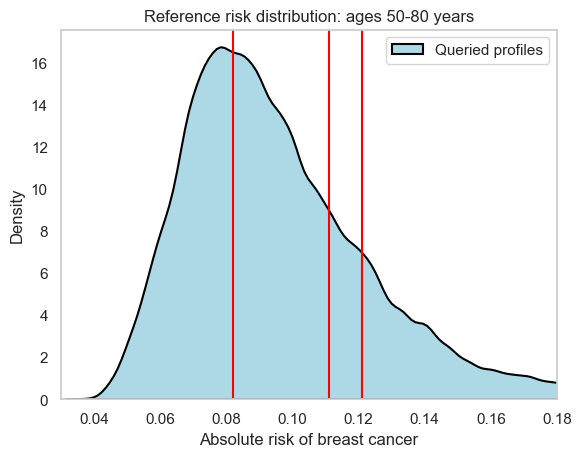

In [12]:
# Density plot of the reference population
sns.kdeplot(reference_risks[0]["population_risks"], bw_adjust=0.5, color="black", fill=True, alpha=0.3, linewidth=1.5, facecolor="lightblue")
plt.xlim(0.03, 0.18)
plt.xlabel("Absolute risk of breast cancer")
plt.title("Reference risk distribution: ages 50-80 years")

# Add a vertical red line, one for each queried profile
for risk_value in profiles["risk_estimates"]:
    plt.axvline(risk_value, color="red")

plt.legend(["Queried profiles"], loc="upper right")

plt.show()